In [ ]:
import pandas as pd
import numpy as np

from os import path
import os, zipfile
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from ipywidgets import Button, HBox, VBox
import ipywidgets as widgets
from IPython.display import FileLink, FileLinks
from IPython.display import display, clear_output

# 1. Make sure to upload your `endlessdice-201903.zip` to root folder in Google Drive.
1. Download from Victor's email chain.
2. Go to Google Drive
3. New+ -> File upload -> *upload the file* `endlessdice-201903.zip`

#### NOTE: only run the following cell once, if you hit an error, you have to hit Runtime -> Factory Reset Runtime
1. It will ask for a link, make sure to accept with the google drive you uploaded the zip to.
2. Hit accept, copy the pass-string, then copy it back to the notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd gdrive/'My Drive'

Mounted at /content/gdrive
/content/gdrive/My Drive


2. Import Data to Colab, just run the cell. It will take a while

In [ ]:
def clean_file(file):
    # the current version of clean_file only checks for 
    banks = ['eossuperplay', 'endlessbank1', 'endlessdicex', 'endlesscrash']
    inspect = pd.read_json(file, lines=True)
    inspect['auth_actor'] = inspect['authorization'].apply(lambda x: x[0]['actor'])
    inspect['auth_perm'] = inspect['authorization'].apply(lambda x: x[0]['permission'])
    inspect = inspect.drop(columns=['authorization'])
    inspect = inspect[~inspect['d_to'].isin(banks)]
    return inspect

def summary(data):
    for col in data.columns:
        print(col)
        display(data[col].value_counts())
        print('\n')

archive = zipfile.ZipFile('endlessdice-201903.zip', 'r')

# num_want is now many we want for now
num_files, num_want = len(archive.namelist()), 20
num_want = num_files

combined = clean_file(archive.open(archive.namelist()[0]))
for i, name in enumerate(archive.namelist()[1:]):
    j = i + 1
    if j % 10 == 1: 
        print("{} / {}".format(j, num_want + 1))
        print(name)
    if j > num_want:
        break
    temp = clean_file(archive.open(name))
    combined = combined.append(temp)
print("finished")

temporal = combined[['d_to', 'trx_timestamp']].rename(columns={'d_to': 'user', 'trx_timestamp': 'time'})
temporal['time'] = pd.to_datetime(temporal['time'])
temporal['weekday'] = temporal['time'].dt.weekday
temporal['hour'] = temporal['time'].dt.hour
temporal.head()

1 / 63
actions-endlessbank1-20190302.json
11 / 63
actions-endlessbank1-20190312.json
21 / 63
actions-endlessbank1-20190322.json
31 / 63
actions-endlessdicex-20190301.json
41 / 63
actions-endlessdicex-20190311.json
51 / 63
actions-endlessdicex-20190321.json
61 / 63
actions-endlessdicex-20190331.json
finished


,user,time,weekday,hour
1,nmslnmslnmsl,2019-03-01 00:00:00,4,0
3,justiceariel,2019-03-01 00:00:03,4,0
5,edgarwinston,2019-03-01 00:00:08,4,0
9,raidenkeegan,2019-03-01 00:00:11,4,0
11,nmslnmslnmsl,2019-03-01 00:00:11,4,0


In [ ]:
temporal.to_csv('temporal-only.csv', index=False, header=False)

Ignore this. This just filters some entries based on a limit, which we currently only set to 1 because clearly if someone makes only one transaction, we have no information.

In [ ]:
obvious_bots = pd.read_csv('https://raw.githubusercontent.com/griffinbaum22/bot_detection/main/obvious_bots').obvious_bots.values
len(obvious_bots)

988

In [ ]:
limit = 1

only_once = temporal.groupby('user').agg('count')[['time']]
display(temporal)
only_once = only_once[only_once['time'] <= limit].index

temporal = temporal[~temporal['user'].isin(only_once)]
times = temporal['time']
obvious_bots = pd.read_csv('https://raw.githubusercontent.com/griffinbaum22/bot_detection/main/obvious_bots').obvious_bots.values
# temporal = temporal[~temporal['user'].isin(obvious_bots)]

,user,time,weekday,hour
1,nmslnmslnmsl,2019-03-01 00:00:00.000,4,0
3,justiceariel,2019-03-01 00:00:03.000,4,0
5,edgarwinston,2019-03-01 00:00:08.000,4,0
9,raidenkeegan,2019-03-01 00:00:11.000,4,0
11,nmslnmslnmsl,2019-03-01 00:00:11.000,4,0
...,...,...,...,...
90274,endlessoptex,2019-03-31 23:59:57.500,6,23
90276,endlessdivdn,2019-03-31 23:59:57.500,6,23
90277,endlessoptex,2019-03-31 23:59:57.500,6,23
90279,endlessdivdn,2019-03-31 23:59:58.000,6,23


Make sure the visualize function displays something normal. If it does, then everything is set up properly.

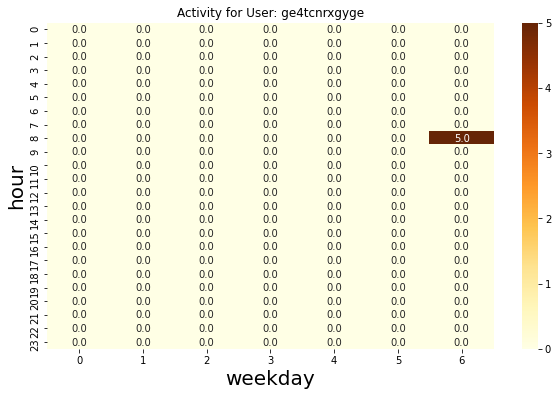

In [ ]:
template = temporal[temporal['user'] == 'nmslnmslnmsl'].groupby(['weekday', 'hour']).agg('count')[['time']]
template['time'] = 0
def visualize_activity(user, center='mean', figsize=(10,6)):
    if user not in set(temporal['user']):
        print('{} DOES NOT EXIST'.format(user))
        return

    # pivot data, there are entries that are empty for now
    pivot_temp = temporal[temporal['user'] == user].groupby(['weekday', 'hour']).agg('count')[['time']]

    # we use nmslnmslnmsl as template since it has entry at every hour, merging with pivot data
    # template = temporal[temporal['user'] == 'nmslnmslnmsl'].groupby(['weekday', 'hour']).agg('count')[['time']]
    template_copy = template.copy()
    template_copy['time'] = pivot_temp['time']
    pivot_temp = template_copy.fillna(0)

    # set mins and max
    min_pivot, max_pivot = min(pivot_temp['time']), max(pivot_temp['time'])

    # plot setting
    pivot_temp = pd.pivot_table(data=pivot_temp,
                                index='hour',
                                columns='weekday',
                                values='time')
    plt.figure(figsize=figsize)
    ax = sns.heatmap(pivot_temp, vmin=min_pivot, vmax=max_pivot,
                    cmap = "YlOrBr",
                    annot=True, fmt=".1f")
    
    # label
    plt.title("Activity for User: {}".format(user))
    ax.set_xlabel('weekday').set_size(20)
    ax.set_ylabel('hour').set_size(20)

sample_name = 'ge4tcnrxgyge'
visualize_activity(sample_name)

In [ ]:
import pickle
def convert_label(i):
    if i == 0:
        return 'bot'
    return 'human'
research_labels = pickle.load(open("groundTruth.pkl", "rb"))
research_labels['research'] = research_labels['label'].apply(convert_label)
research_labels = research_labels[['name', 'research']]
research_labels

FileNotFoundError: ignored

In [ ]:
userCount = temporal.groupby('user').agg('count')
userCount = userCount.drop(['time', 'weekday'], axis=1)
userCount = userCount.rename(columns={"hour": "interactionCount"})
#number of hours active
hoursActive = temporal.groupby(['user', 'weekday', 'hour']).agg('count')
hoursActive['n'] = 1
hoursActive = hoursActive.groupby('user').agg('sum')
hoursActive = hoursActive.drop(['time'], axis=1)
hoursActive = hoursActive.rename(columns={"n": "# of hours active"})
final = userCount.join(hoursActive)
final

,interactionCount,# of hours active
user,,
12345dancing,11,6
12345haoming,3,1
1234luckyone,5,3
12profitup34,6,1
14wkee4teosd,7,2
...,...,...
ztefultajuws,29,9
zu1t1orl5t2e,31,9
zuboxrwlypgg,30,8


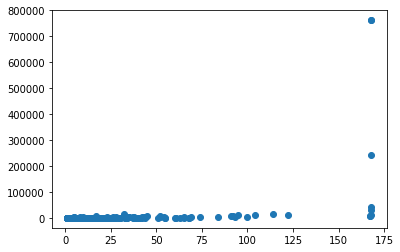

In [ ]:
X = final["# of hours active"]
Y = final["interactionCount"]
plt.scatter(X,Y)

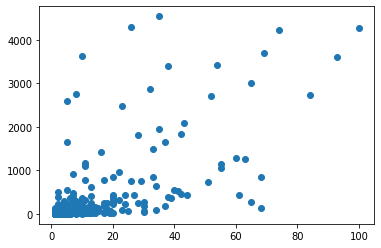

In [ ]:
#removing extremely large outliers since they are clearly bots to see the rest of the data more clearly
final = final[final["interactionCount"] < 5000]
#remove outliers or obvious bots here
X = final["# of hours active"]
Y = final["interactionCount"]
plt.scatter(X,Y)

In [ ]:
user_arr = final.index.values
final.reset_index(drop=True, inplace=True)
X = final.to_numpy()
user_arr

array(['12345dancing', '12345haoming', '1234luckyone', ...,
       'zuboxrwlypgg', 'zzxzzxzzxzzx', 'zzzssszzz321'], dtype=object)

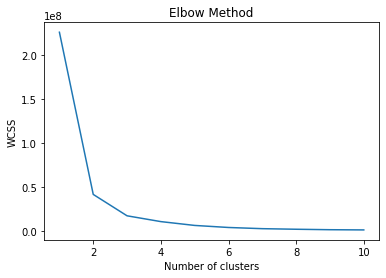

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
#In cluster analysis, the elbow method is a heuristic used in determining the number of clusters in a data set. 
#The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use

Text(0.5, 1.0, 'Two Cluster K-Means')

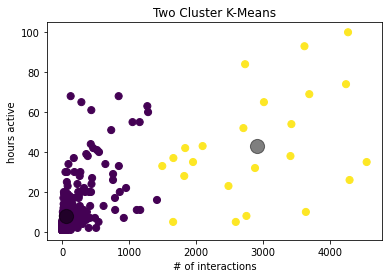

In [ ]:
kmeans = KMeans(n_clusters=2)
pred_y = kmeans.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=pred_y, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlabel('# of interactions')
plt.ylabel('hours active')
plt.title('Two Cluster K-Means')

Text(0.5, 1.0, 'Four Cluster K-Means')

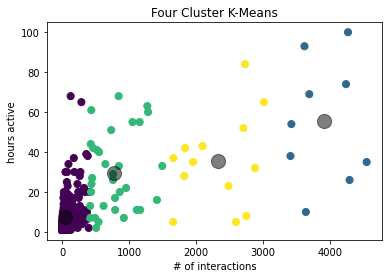

In [ ]:
kmeans = KMeans(n_clusters=4)
pred_y = kmeans.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=pred_y, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlabel('# of interactions')
plt.ylabel('hours active')
plt.title('Four Cluster K-Means');